# Lambda Sarsa

Here we added eligibility trace to the SARSA algoritghm. Eligibility trace is, in some sense, closing the gap between SARSA and monte carlo, by making the bootstrap of SARSA less drastic. What we implement here is also called the "backward view of TD($\lambda$)".

The idea is that we track an eligibility trace for each state action pair $ET(s, a)$. At every episode they start at 0, and every time we select an action $a_t$ in a new state $s_t$ this gets updated by

$$ ET(s,a) \leftarrow \lambda \gamma ET(s,a) \: \: \: \forall (s, a) \neq (s_t, a_t) \in S \times A$$

while for $(s_t, a_t)$ we use one of the following rules

$$ ET(s_t, a_t) \leftarrow
    \begin{cases}
        \begin{align}
            &1 &\textrm{replacing}\\
            &\lambda \gamma ET(s_t,a_t) + 1 &\textrm{accumulating}\\
            &(1 - \alpha)\lambda \gamma ET(s_t,a_t) + 1 &\textrm{dutch}\\
        \end{align}
    \end{cases}
$$

Where $\lambda$  is a new hyperparameter. Intuitively this just keeps track of how recently(and often) a state action pair has been visited. 

Using this we can do updates to our $Q$ function not only to $(s_t,a_t)$, but to every state action pair: 
$$\delta = R_t + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t})$$
$$ Q(s, a) \leftarrow Q(s, a) + \alpha \delta ET(s, a) $$

Then we proced to do everything else just as in the SARSA algorithm.

In [1]:
import sys

sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import itertools

from exploring_agents import LambdaSarsaAgent
from exploring_agents.training import run_episode, train_agent
from grid_world.action import Action
from grid_world.grid_world import GridWorld
from grid_world.visualization.format_objects import (
    get_policy_rec_str,
    get_policy_eval_str,
    get_world_str,
)
from utils.returns import returns_from_reward
from utils.policy import get_policy_rec, get_random_policy, sample_action
from notebooks.utils.worlds import small_world_03
from notebooks.utils.basics import basic_actions, basic_reward
from notebooks.utils.experimentation import (
    get_exp_results,
    get_results,
    moving_average,
    get_summary_df,
)


np.random.seed(21)

In [2]:
alpha = 0.7
epsilon = 0.01
gworld = small_world_03
print(get_world_str(gworld))

6                ✘ 

5 ☠  ☠     █     █ 

4          █       

3    ☠  ☠  █  █    

2                  

1    █  █  █  █    

0 ⚐                

  0  1  2  3  4  5 


In [3]:
agent = LambdaSarsaAgent(
    reward_function=basic_reward,
    actions=basic_actions,
    gamma=1,
    alpha=alpha,
    epsilon=epsilon,
)

episode_lengths, episode_returns = train_agent(
    agent=agent, world=small_world_03, episodes=50
)
pi_r = get_policy_rec(agent.policy, small_world_03, agent.actions)

print(get_policy_rec_str(pi_r, small_world_03))

 ↓  →  ↓  ↑  →  ✘ 

 ☠  ☠  ↑  █  ↑  █ 

 ↑  ↑  ↑  █  ↑  ← 

 ↑  ☠  ☠  █  █  ↑ 

 ↓  →  →  →  →  ↑ 

 ↓  █  █  █  █  ↑ 

 →  →  →  →  →  ↑ 




## Hyperparameters

Since this agent has some new parameters, lets check how they affect performance. We will examine the "kind" and $\lambda$ values of the eligibility trace.

We will be using $\epsilon = 0.01$, so it is expected that policies prefer taking the longer path.

In [4]:
training_rounds = 200
episodes = 200

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "alpha": alpha,
    "epsilon": epsilon,
}
arguments = {
    "et_kind": ["accumulating", "dutch", "replacing"],
    "et_lambda": [0.1, 0.3, 0.7],
}

results = get_exp_results(
    LambdaSarsaAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,et_kind,et_lambda,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
2,accumulating,0.7,-3284.00,220.83,-12.74,3.36,13
5,dutch,0.7,-3365.44,246.87,-13.02,9.66,13
8,replacing,0.7,-3400.10,244.72,-12.75,5.16,13
1,accumulating,0.3,-3596.42,165.92,-12.65,5.52,13
4,dutch,0.3,-3644.54,153.71,-12.76,6.55,13
7,replacing,0.3,-3662.70,161.05,-12.78,5.89,13
0,accumulating,0.1,-4296.56,216.09,-12.85,7.85,11
6,replacing,0.1,-4305.30,215.49,-12.92,10.32,11
3,dutch,0.1,-4323.02,189.44,-12.53,5.11,11


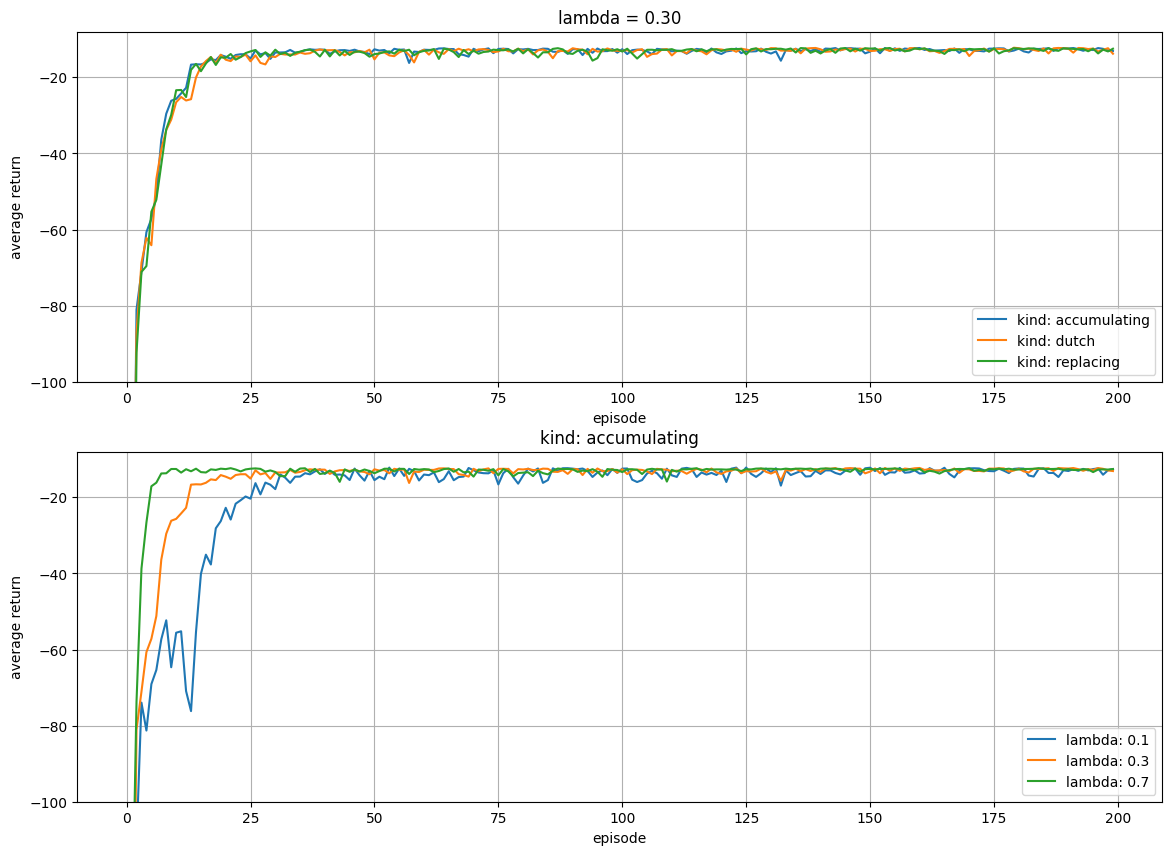

In [5]:
fig, axs = plt.subplots(2, figsize=(14, 10))

for (params, values) in results:
    if params["et_lambda"] == 0.30:
        axs[0].plot(
            np.mean(np.array(values[0]), axis=0), label=f'kind: {params["et_kind"]}'
        )

axs[0].set(xlabel="episode", ylabel="average return", ylim=[-100, -8])
axs[0].grid()
axs[0].legend(loc="lower right")
axs[0].set_title("lambda = 0.30")

for (params, values) in results:
    if params["et_kind"] == "accumulating":
        axs[1].plot(
            np.mean(np.array(values[0]), axis=0), label=f'lambda: {params["et_lambda"]}'
        )

axs[1].set(xlabel="episode", ylabel="average return", ylim=[-100, -8])
axs[1].grid()
axs[1].legend(loc="lower right")
axs[1].set_title("kind: accumulating")


plt.show()

The new parameter $\lambda$ does seem to have a nice impact over our algorithm, while the kind seems almost irrelevant; lets focus a little more on $\lambda$ then. The bigger impact seems to be on how fast the agent gets to a good police, so lets restrict our analysis to the first 50 episodes.

Higher values of $\lambda$ make the algorithm closer to Monte Carlo; and for high enough values the performance gets so bad that the code starts getting really slow. Increasing epsilon helps with this, so I will use a higher value.

In [6]:
epsilon = 0.05
training_rounds = 100
episodes = 50

base_arguments = {
    "reward_function": basic_reward,
    "actions": basic_actions,
    "alpha": alpha,
    "epsilon": epsilon,
}
arguments = {"et_lambda": [0.3, 0.65, 0.7, 0.75, 0.8, 0.85]}

results = get_exp_results(
    LambdaSarsaAgent,
    small_world_03,
    base_arguments,
    arguments,
    episodes,
    training_rounds,
)

results_df = get_summary_df(results)
display(
    results_df.round(
        {
            "average_round_reward": 2,
            "std_round_reward": 2,
            "average_reward_final_10": 2,
            "std_reward_final_10": 2,
        }
    )
)

,et_lambda,average_round_reward,std_round_reward,average_reward_final_10,std_reward_final_10,shortest_run
1,0.65,-1548.80,175.78,-15.37,9.71,13
2,0.70,-1566.17,198.53,-15.16,5.09,13
3,0.75,-1680.42,289.80,-17.78,33.86,13
4,0.80,-1795.44,518.38,-18.90,41.35,13
0,0.30,-1942.41,168.88,-16.12,17.03,13
5,0.85,-11445.75,27096.07,-76.81,446.92,13


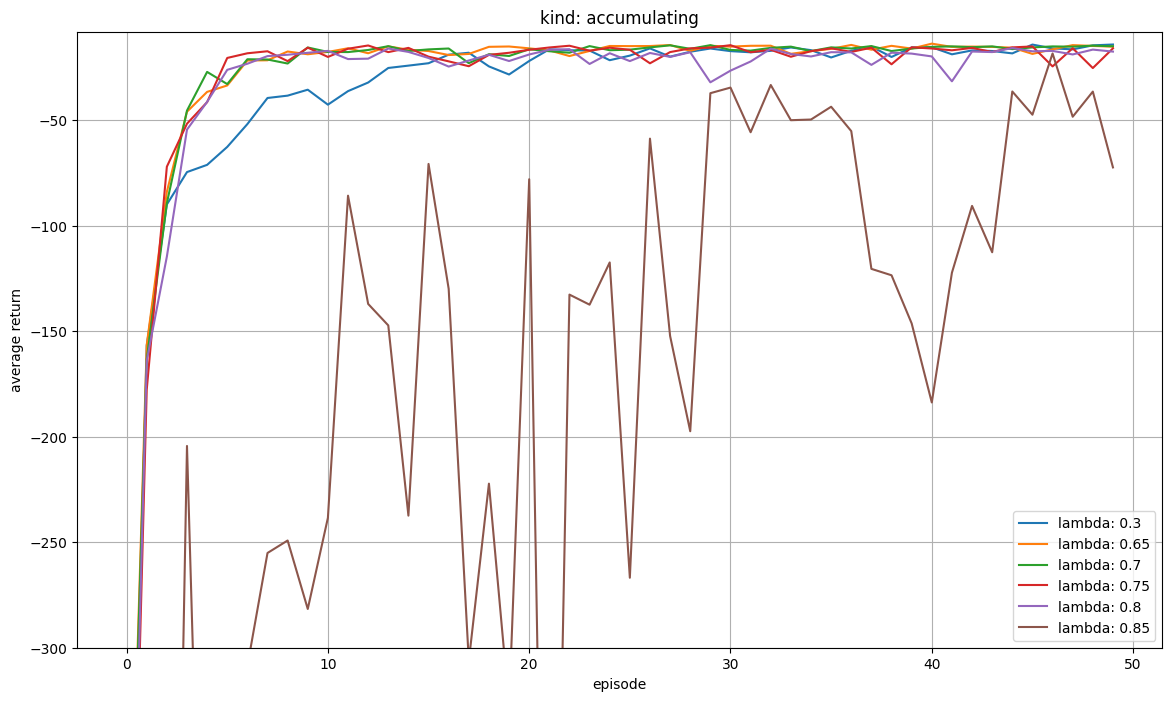

In [7]:
fig, ax = plt.subplots(figsize=(14, 8))

for (params, values) in results:
    ax.plot(
        np.mean(np.array(values[0]), axis=0), label=f'lambda: {params["et_lambda"]}'
    )

ax.set(xlabel="episode", ylabel="average return", ylim=[-300, -8])
ax.grid()
ax.legend(loc="lower right")
ax.set_title("kind: accumulating")


plt.show()

We manage to get quite a performance boost with this algorithm for a range of values of lambda. However setting lambda too high can make things go really poorly, so we should be careful with this parameter.